In [3]:
# Import libraries
import numpy as np 
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('dark_background')

---

# What is a state-space model? 

State space model (SSM) refers to a class of probabilistic graphical model (Koller and Friedman, 2009) that describes the probabilistic dependence between the latent state variable and the observed measurement. The state or the measurement can be either continuous or discrete. The term “state space” originated in 1960s in the area of control engineering (Kalman, 1960). SSM provides a general framework for analyzing deterministic and stochastic dynamical systems that are measured or observed through a stochastic process. The SSM framework has been successfully applied in engineering, statistics, computer science and economics to solve a broad range of dynamical systems problems. Other terms used to describe SSMs are hidden Markov models (HMMs) (Rabiner, 1989) and latent process models. The most well studied SSM is the Kalman filter, which defines an optimal algorithm for inferring linear Gaussian systems.

An important objective of computational neuroscience is to develop statistical techniques to characterize the dynamic features inherent in neural and behavioral responses of experimental subjects collected during neurophysiological experiments. In neuroscience experiments, measurements of neural or behavioral data are often dynamic, noisy and have rich temporal structures. Examples of such include intracellular or extracellular recordings, neuronal spike trains, local field potentials, EEG, MEG, fMRI, calcium imaging, and behavioral measures (such as the reaction time and decision choice). Questions of interest may include how to analyze spike trains from ensembles of hippocampal place cells to infer the rodent’s position in the environment or how to identify the sources of dipole using multi-channel MEG recordings. Regardless of their specific modality and applications, SSM provides a unified and powerful paradigm to model and analyze these signals in a dynamic fashion in both time and space.

*From scholarpedia.org

# Figure 1

## Single-State Model

$x(n+1) = A \cdot x(n) + B \cdot e(n)$

 ---

## Gain-Specific Model 

$x_1(n+1) = min(0, [A \cdot x_1(n) + B \cdot e(n)])$

$x_2(n+1) = max(0, [A \cdot x_2(n) + B \cdot e(n)])$

$B_f > B_s, A_s > A_f$

$x = x_1 + x_2$

---

## Multi-Rate Model 

$x_1(n+1) = A_f \cdot x_1(n) + B_f \cdot e(n)$

$x_2(n+1) = A_s \cdot x_2(n) + B_s \cdot e(n)$

$B_f > B_s, A_s > A_f$

$x = x_1 + x_2$

---

## Variables

$x(n) - \textit{Net motor output on trial n}$

$x_1,x_2 - \textit{Internal states that contribute to the net motor output}$

$e(n) - \textit{Error on trial n}$

$B - \textit{Learning rate}$

$A - \textit{Retention factor}$

---



## A 

### Perturbation schedule

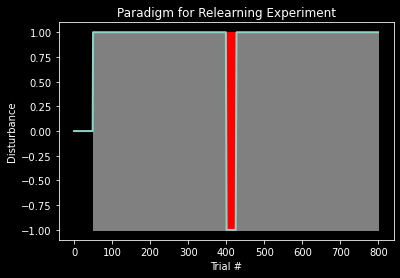

In [4]:
# Create data frame 
data = np.zeros([800,1])
design = pd.DataFrame(data = data, columns = ['disturbance'])
design['disturbance'][0:49] = 0 # null trials 
design['disturbance'][50:400] = 1 # adaptation trials 
design['disturbance'][401:426] = -1 # de-adaptation trials 
design['disturbance'][427:800] = 1 # re-adaptation trials

# Plot 
plt.figure()
plt.plot(design['disturbance'], linewidth=2)
plt.fill_between([50, 400], [1], [-1], color='gray')
plt.fill_between([401, 426], [1], [-1], color='red')
plt.fill_between([427, 800], [1], [-1], color='gray')
plt.xlabel('Trial #')
plt.ylabel('Disturbance')
plt.title('Paradigm for Relearning Experiment')
plt.show()

## B 

### Single-State Model

$x(n+1) = A \cdot x(n) + B \cdot e(n)$

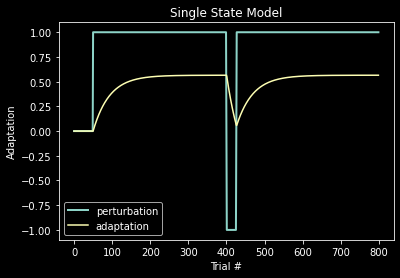

In [5]:
# Create data frame
data = np.zeros([800,2])
design_single = pd.DataFrame(data = data, 
                             columns = ['disturbance', 'x'])
design_single['disturbance'] = design['disturbance']

# rates
A = 0.99
B = 0.013
# ICs
x = 0 

# Simulate 
for i in np.arange(0,799):
  # error 
  er = design_single['disturbance'][i] - design_single['x'][i]
  # adaptation 
  design_single['x'][i+1] = A * x + B * er
  # update 
  x = design_single['x'][i+1]

# plot 
plt.figure()
plt.plot(design_single['disturbance'], linewidth=2, label='perturbation')
plt.plot(design_single['x'], label='adaptation')
plt.xlabel('Trial #')
plt.ylabel('Adaptation')
plt.legend(loc='best')
plt.title('Single State Model')
plt.show()

### Gain-Specific Model 

$x_1(n+1) = min(0, [A \cdot x_1(n) + B \cdot e(n)])$

$x_2(n+1) = max(0, [A \cdot x_2(n) + B \cdot e(n)])$

$B_f > B_s, A_s > A_f$

$x = x_1 + x_2$

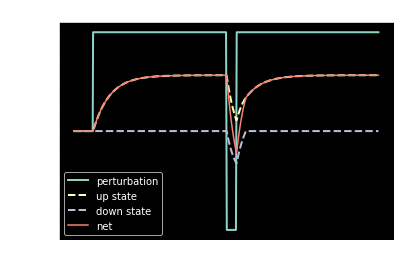

In [ ]:
# Create data frame
data = np.zeros([800,5])
design_gain = pd.DataFrame(data = data, 
                             columns = ['disturbance', 'x', 'up', 'down', 'net'])
design_gain['disturbance'] = design['disturbance']

# ICs
x_1 = 0 
x_2 = 0

# Simulate 
for i in np.arange(0,799): 
  # error 
  er = design_gain['disturbance'][i] - design_gain['net'][i]
  # up state (somehow need to max)
  design_gain['up'][i+1] = np.max([0, A * x_1 + B * er])
  # down state (somehow need to min)
  design_gain['down'][i+1] = np.min([0, A * x_2 + B * er])
  # net 
  design_gain['net'][i+1] = design_gain['up'][i+1] + design_gain['down'][i+1]
  # update 
  x_1 = design_gain['up'][i+1]
  x_2 = design_gain['down'][i+1]

# plot 
plt.figure()
plt.plot(design_single['disturbance'], linewidth=2, label='perturbation')
plt.plot(design_gain['up'], linewidth=2, linestyle='--', label='up state')
plt.plot(design_gain['down'], linewidth=2, linestyle='--', label='down state')
plt.plot(design_gain['net'], linewidth=1.5, label='net')
plt.xlabel('Trial #')
plt.ylabel('Adaptation')
plt.title('Gain-Specific Model')
plt.legend(loc='best')
plt.show()

### Multi-Rate Model 

$x_1(n+1) = A_f \cdot x_1(n) + B_f \cdot e(n)$

$x_2(n+1) = A_s \cdot x_2(n) + B_s \cdot e(n)$

$B_f > B_s, A_s > A_f$

$x = x_1 + x_2$

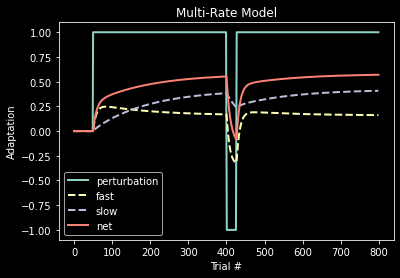

In [6]:
# Create data frame
data = np.zeros([800,5])
design_multi = pd.DataFrame(data = data, 
                             columns = ['disturbance', 'x', 'fast', 'slow', 'net'])
design_multi['disturbance'] = design['disturbance']

# rates
A_f = 0.92
A_s = 0.996
B_f = 0.03
B_s = 0.004

# ICs
x_1 = 0 
x_2 = 0

# Simulate 
for i in np.arange(0,799):
  # error 
  er = design_multi['disturbance'][i] - design_multi['net'][i]
  # fast
  design_multi['fast'][i+1] = (A_f * x_1) + (B_f * er)
  # slow
  design_multi['slow'][i+1] = (A_s * x_2) + (B_s * er)
  # net
  design_multi['net'][i+1] = design_multi['fast'][i+1] + design_multi['slow'][i+1]
  # update 
  x_1 = design_multi['fast'][i+1]
  x_2 = design_multi['slow'][i+1]

# plot 
plt.figure()
plt.plot(design_single['disturbance'], linewidth=2, label='perturbation')
plt.plot(design_multi['fast'], linewidth=2, linestyle='--', label='fast')
plt.plot(design_multi['slow'], linewidth=2, linestyle='--',label='slow')
plt.plot(design_multi['net'], linewidth=2, label='net')
plt.xlabel('Trial #')
plt.title('Multi-Rate Model')
plt.ylabel('Adaptation')
plt.legend(loc='best')
plt.show()

## C

Plot the first 300 trials of learning and relearning. 

### Single-State Model

$x(n+1) = A \cdot x(n) + B \cdot e(n)$

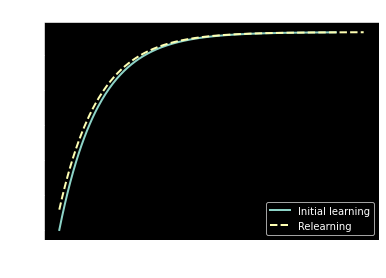

In [ ]:
learning = design_single['x'][50:350]
relearning = design_single['x'][427:757]

plt.figure()
plt.plot(np.arange(0,300), learning, linewidth=2, linestyle='-', label='Initial learning')
plt.plot(np.arange(0,len(relearning)), relearning, linewidth=2, linestyle='--', label='Relearning')
plt.xlabel('Trials')
plt.ylabel('Adaptation')
plt.legend(loc='best')
plt.title('Single-State Model')
plt.show();

### Gain-Specific Model

$x_1(n+1) = min(0, [A \cdot x_1(n) + B \cdot e(n)])$

$x_2(n+1) = max(0, [A \cdot x_2(n) + B \cdot e(n)])$

$B_f > B_s, A_s > A_f$

$x = x_1 + x_2$

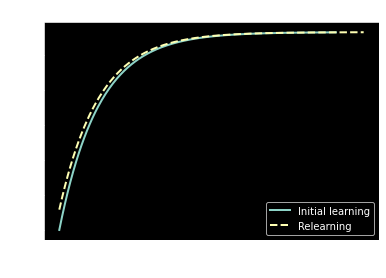

In [ ]:
learning = design_single['x'][50:350]
relearning = design_single['x'][427:757]

plt.figure()
plt.plot(np.arange(0,300), learning, linewidth=2, linestyle='-', label='Initial learning')
plt.plot(np.arange(0,len(relearning)), relearning, linewidth=2, linestyle='--', label='Relearning')
plt.xlabel('Trials')
plt.ylabel('Adaptation')
plt.legend(loc='best')
plt.title('Gain-Specific Model')
plt.show();

### Multi-Rate Model

$x_1(n+1) = A_f \cdot x_1(n) + B_f \cdot e(n)$

$x_2(n+1) = A_s \cdot x_2(n) + B_s \cdot e(n)$

$B_f > B_s, A_s > A_f$

$x = x_1 + x_2$

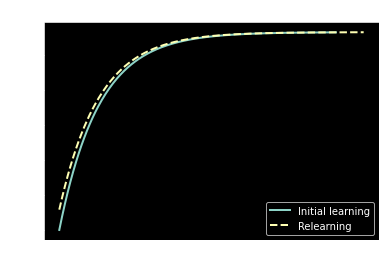

In [ ]:
learning = design_single['x'][50:350]
relearning = design_single['x'][427:757]

plt.figure()
plt.plot(np.arange(0,300), learning, linewidth=2, linestyle='-', label='Initial learning')
plt.plot(np.arange(0,len(relearning)), relearning, linewidth=2, linestyle='--', label='Relearning')
plt.xlabel('Trials')
plt.ylabel('Adaptation')
plt.legend(loc='best')
plt.title('Multi-Rate Model')
plt.show();

## D

### Relearning Experiment with Washout

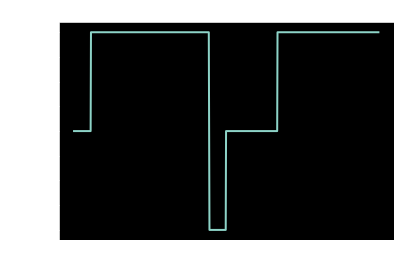

In [ ]:
# Create data frame 
data = np.zeros([900,1])
design_wo = pd.DataFrame(data = data, columns = ['disturbance'])
design_wo['disturbance'][0:49] = 0 # null trials 
design_wo['disturbance'][50:399] = 1 # adaptation trials 
design_wo['disturbance'][400:449] = -1 # de-adaptation trials 
design_wo['disturbance'][450:600] = 0 # washout trials
design_wo['disturbance'][601:900] = 1 # re-adaptation trials 

# Plot 
plt.figure()
plt.plot(design_wo['disturbance'], linewidth=2)
plt.xlabel('Trial #')
plt.ylabel('Disturbance')
plt.title('Paradigm for Relearning Experiment with Washout')
plt.show()

## E

### Single-State Model

$x(n+1) = A \cdot x(n) + B \cdot e(n)$

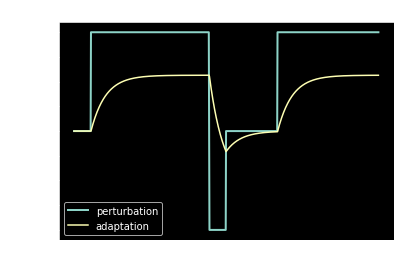

In [ ]:
# Create function for new paradigm 
def single_state(num_washout):
  # INPUTS:
  # num_washout: number of washout trials 

  # OUTPUT:
  # design_wo_single: data frame holding perturbation schedule and adaptation value

  # Perturbation schedule 
  data = np.zeros([900,1])
  design_wo = pd.DataFrame(data = data, columns = ['disturbance'])
  design_wo['disturbance'][0:49] = 0 # null trials 
  design_wo['disturbance'][50:399] = 1 # adaptation trials 
  design_wo['disturbance'][400:449] = -1 # de-adaptation trials 
  design_wo['disturbance'][450:450+num_washout] = 0 # washout trials
  design_wo['disturbance'][450+num_washout+1:900] = 1 # re-adaptation trials 

  # Create data frame
  data = np.zeros([900,2])
  design_wo_single = pd.DataFrame(data = data, 
                              columns = ['disturbance', 'x'])
  design_wo_single['disturbance'] = design_wo['disturbance']

  # rates
  A = 0.99
  B = 0.013
  # ICs
  x = 0 

  # Simulate 
  for i in np.arange(0,899):
    # error 
    er = design_wo_single['disturbance'][i] - design_wo_single['x'][i]
    # adaptation 
    design_wo_single['x'][i+1] = A * x + B * er
    # update 
    x = design_wo_single['x'][i+1]

  return design_wo_single

# Test with 150 washout 
design_wo_single = single_state(150)
plt.figure()
plt.plot(design_wo_single['disturbance'], linewidth=2, label='perturbation')
plt.plot(design_wo_single['x'], label='adaptation')
plt.xlabel('Trial #')
plt.ylabel('Adaptation')
plt.title('Single State Model')
plt.legend(loc='best')
plt.show()

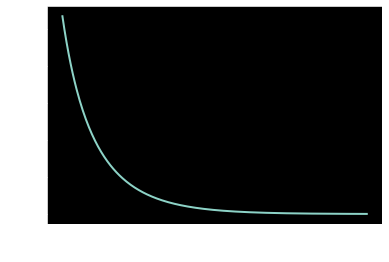

In [ ]:
# Calculate percent savings as a function of number of trials 
savings = np.zeros(shape=[300,1])
for i in np.arange(0,300):
  design_wo_single = single_state(i);
  savings[i] = design_wo_single['x'][80] / design_wo_single['x'][450+i+1+30]

plt.figure()
plt.plot(np.arange(0,300), savings*100, linewidth=2)
plt.ylabel('% savings')
plt.xlabel('# of washout trials')
# plt.gca().set_ylim(bottom=0,top=100)
plt.show()

### Gain-Specific Model

$x_1(n+1) = min(0, [A \cdot x_1(n) + B \cdot e(n)])$

$x_2(n+1) = max(0, [A \cdot x_2(n) + B \cdot e(n)])$

$B_f > B_s, A_s > A_f$

$x = x_1 + x_2$

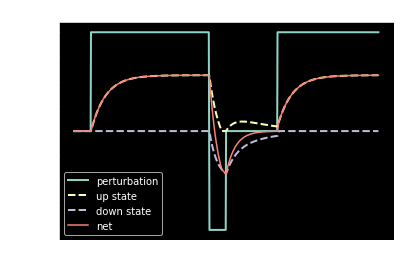

In [ ]:
# Create function
def gain_model(num_washout):
  # INPUT:
  # num_washout: number of washout trials

  # OUTPUT:
  # design_wo_gain: design data frame for gain specific model with varying washout trials 

  # Perturbation schedule 
  data = np.zeros([900,1])
  design_wo = pd.DataFrame(data = data, columns = ['disturbance'])
  design_wo['disturbance'][0:49] = 0 # null trials 
  design_wo['disturbance'][50:399] = 1 # adaptation trials 
  design_wo['disturbance'][400:449] = -1 # de-adaptation trials 
  design_wo['disturbance'][450:450+num_washout] = 0 # washout trials
  design_wo['disturbance'][450+num_washout+1:900] = 1 # re-adaptation trials 

  # Create data frame
  data = np.zeros([900,5])
  design_wo_gain = pd.DataFrame(data = data, 
                              columns = ['disturbance', 'x', 'up', 'down', 'net'])
  design_wo_gain['disturbance'] = design_wo['disturbance']

  # ICs
  x_1 = 0 
  x_2 = 0

  # Simulate 
  for i in np.arange(0,899): 
    # error 
    er = design_wo_gain['disturbance'][i] - design_wo_gain['net'][i]
    # up state (somehow need to max)
    design_wo_gain['up'][i+1] = np.max([0, A * x_1 + B * er])
    # down state (somehow need to min)
    design_wo_gain['down'][i+1] = np.min([0, A * x_2 + B * er])
    # net 
    design_wo_gain['net'][i+1] = design_wo_gain['up'][i+1] + design_wo_gain['down'][i+1]
    # update 
    x_1 = design_wo_gain['up'][i+1]
    x_2 = design_wo_gain['down'][i+1]

  return design_wo_gain

# Test with 150 washout trials 
design_wo_gain = gain_model(150)
plt.figure()
plt.plot(design_wo_gain['disturbance'], linewidth=2, label='perturbation')
plt.plot(design_wo_gain['up'], linewidth=2, linestyle='--', label='up state')
plt.plot(design_wo_gain['down'], linewidth=2, linestyle='--', label='down state')
plt.plot(design_wo_gain['net'], linewidth=1.5, label='net')
plt.xlabel('Trial #')
plt.title('Gain-Specific Model')
plt.ylabel('Adaptation')
plt.legend(loc='best')
plt.show()

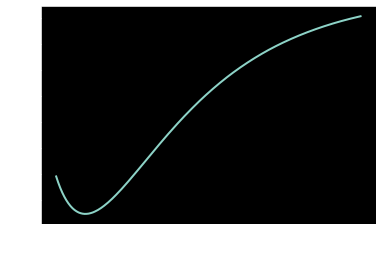

In [ ]:
# Calculate percent savings as a function of number of trials 
savings = np.zeros(shape=[300,1])
for i in np.arange(0,300):
  design_wo_gain = gain_model(i);
  savings[i] = design_wo_gain['net'][80] / design_wo_gain['net'][450+i+1+30]

plt.figure()
plt.plot(np.arange(0,300), savings*100, linewidth=2)
plt.ylabel('% savings')
plt.xlabel('# of washout trials')
plt.show()

### Multi-Rate Model

$x_1(n+1) = A_f \cdot x_1(n) + B_f \cdot e(n)$

$x_2(n+1) = A_s \cdot x_2(n) + B_s \cdot e(n)$

$B_f > B_s, A_s > A_f$

$x = x_1 + x_2$

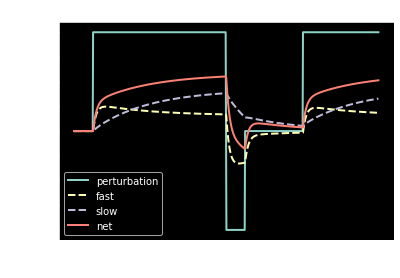

In [ ]:
# Create function 
def multi_rate(num_washout):
  # INPUT:
  # num_washout: number of washout trials 

  # design_wo_multi: design data frame for multi rate model 

  # Perturbation schedule 
  data = np.zeros([900,1])
  design_wo = pd.DataFrame(data = data, columns = ['disturbance'])
  design_wo['disturbance'][0:49] = 0 # null trials 
  design_wo['disturbance'][50:399] = 1 # adaptation trials 
  design_wo['disturbance'][400:449] = -1 # de-adaptation trials 
  design_wo['disturbance'][450:450+num_washout] = 0 # washout trials
  design_wo['disturbance'][450+num_washout+1:900] = 1 # re-adaptation trials 

  # Create data frame
  data = np.zeros([800,5])
  design_wo_multi = pd.DataFrame(data = data, 
                              columns = ['disturbance', 'x', 'fast', 'slow', 'net'])
  design_wo_multi['disturbance'] = design_wo['disturbance']

  # rates
  A_f = 0.92
  A_s = 0.996
  B_f = 0.03
  B_s = 0.004

  # ICs
  x_1 = 0 
  x_2 = 0

  # Simulate 
  for i in np.arange(0,799):
    # error 
    er = design_wo_multi['disturbance'][i] - design_wo_multi['net'][i]
    # fast
    design_wo_multi['fast'][i+1] = (A_f * x_1) + (B_f * er)
    # slow
    design_wo_multi['slow'][i+1] = (A_s * x_2) + (B_s * er)
    # net
    design_wo_multi['net'][i+1] = design_wo_multi['fast'][i+1] + design_wo_multi['slow'][i+1]

    # update 
    x_1 = design_wo_multi['fast'][i+1]
    x_2 = design_wo_multi['slow'][i+1]

  return design_wo_multi

# Test with 150 washout trials  
design_wo_multi = multi_rate(150)
plt.figure()
plt.plot(design_wo_multi['disturbance'], linewidth=2, label='perturbation')
plt.plot(design_wo_multi['fast'], linewidth=2, linestyle='--', label='fast')
plt.plot(design_wo_multi['slow'], linewidth=2, linestyle='--',label='slow')
plt.plot(design_wo_multi['net'], linewidth=2, label='net')
plt.xlabel('Trial #')
plt.title('Multi-Rate Model')
plt.ylabel('Adaptation')
plt.legend(loc='best')
plt.show()

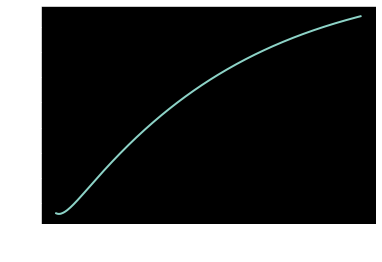

In [ ]:
# Calculate percent savings as a function of number of trials 
savings = np.zeros(shape=[300,1])
for i in np.arange(0,300):
  design_wo_multi = multi_rate(i);
  savings[i] = design_wo_multi['net'][80] / design_wo_multi['net'][450+i+1+30]

plt.figure()
plt.plot(np.arange(0,300), savings*100, linewidth=2)
plt.ylabel('% savings')
plt.xlabel('# of washout trials')
plt.show()

---

# Figure 2

## A

### Perturbation schedule

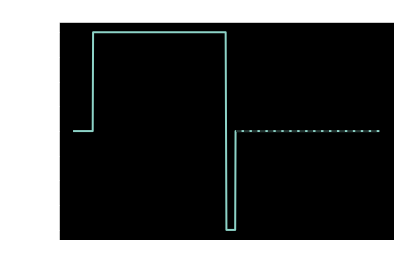

In [ ]:
# Schedule
data = np.zeros([800,1])
design_er = pd.DataFrame(data = data, columns = ['disturbance'])
design_er['disturbance'][0:49] = 0 # null trials 
design_er['disturbance'][50:399] = 1 # adaptation trials 
design_er['disturbance'][400:424] = -1 # de-adaptation trials 
design_er['disturbance'][425:800] = 0 # error clamp trials

# Visualize 
plt.figure()
plt.plot(design_er['disturbance'], linewidth=2,label='perturbation')
plt.plot(np.arange(425,800), [0] * 375, linestyle='--', color='k')
plt.xlabel('Trial #')
plt.ylabel('Disturbance')
plt.title('Error clamp paradigm')
plt.show()

## B

### Single-state Model 

$x(n+1) = A \cdot x(n) + B \cdot e(n)$

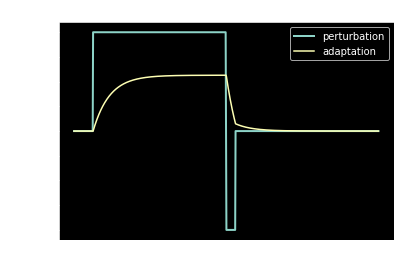

In [ ]:
# Create data frame
data = np.zeros([800,2])
design_er_single = pd.DataFrame(data = data, 
                             columns = ['disturbance', 'x'])
design_er_single['disturbance'] = design_er['disturbance']

# rates
A = 0.99
B = 0.013
# ICs
x = 0 

# Simulate 
er = np.zeros(shape=[800,1])
for i in np.arange(0,799):
  # error 
  er[i] = design_er_single['disturbance'][i] - design_er_single['x'][i]

  # adaptation 
  design_er_single['x'][i+1] = A * x + B * er[i]

  # update 
  x = design_er_single['x'][i+1]

# plot 
plt.figure()
plt.plot(design_er_single['disturbance'], linewidth=2, label='perturbation')
plt.plot(design_er_single['x'], label='adaptation')
# plt.plot(er, label='error')
plt.xlabel('Trial #')
plt.ylabel('Adaptation')
plt.title('Single State Model')
plt.legend(loc='best')
plt.show()

### Gain-specific Model 

$x_1(n+1) = min(0, [A \cdot x_1(n) + B \cdot e(n)])$

$x_2(n+1) = max(0, [A \cdot x_2(n) + B \cdot e(n)])$

$B_f > B_s, A_s > A_f$

$x = x_1 + x_2$

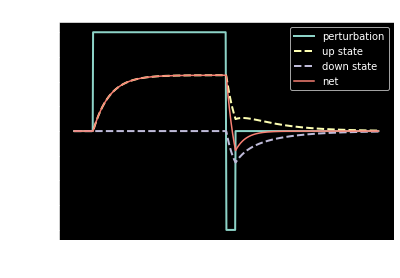

In [ ]:
# Create data frame
data = np.zeros([800,5])
design_er_gain = pd.DataFrame(data = data, 
                             columns = ['disturbance', 'x', 'up', 'down', 'net'])
design_er_gain['disturbance'] = design_er['disturbance']

# ICs
x_1 = 0 
x_2 = 0

# Simulate 
for i in np.arange(0,799): 
  # error 
  er = design_er_gain['disturbance'][i] - design_er_gain['net'][i]
  # up state (somehow need to max)
  design_er_gain['up'][i+1] = np.max([0, A * x_1 + B * er])
  # down state (somehow need to min)
  design_er_gain['down'][i+1] = np.min([0, A * x_2 + B * er])
  # net 
  design_er_gain['net'][i+1] = design_er_gain['up'][i+1] + design_er_gain['down'][i+1]
  # update 
  x_1 = design_er_gain['up'][i+1]
  x_2 = design_er_gain['down'][i+1]

# plot 
plt.figure()
plt.plot(design_er_gain['disturbance'], linewidth=2, label='perturbation')
plt.plot(design_er_gain['up'], linewidth=2, linestyle='--', label='up state')
plt.plot(design_er_gain['down'], linewidth=2, linestyle='--', label='down state')
plt.plot(design_er_gain['net'], linewidth=1.5, label='net')
plt.xlabel('Trial #')
plt.ylabel('Adaptation')
plt.title('Gain-Specific Model')
plt.legend(loc='best')
plt.show()

### Multi-Rate Model 

$x_1(n+1) = A_f \cdot x_1(n) + B_f \cdot e(n)$

$x_2(n+1) = A_s \cdot x_2(n) + B_s \cdot e(n)$

$B_f > B_s, A_s > A_f$

$x = x_1 + x_2$

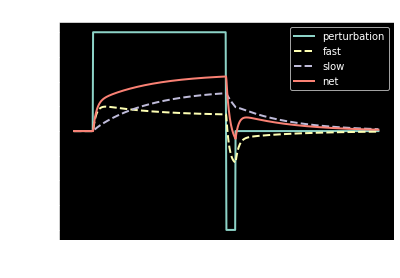

In [ ]:
# Create data frame
data = np.zeros([800,5])
design_er_multi = pd.DataFrame(data = data, 
                             columns = ['disturbance', 'x', 'fast', 'slow', 'net'])
design_er_multi['disturbance'] = design_er['disturbance']

# rates
A_f = 0.92
A_s = 0.996
B_f = 0.03
B_s = 0.004

# ICs
x_1 = 0 
x_2 = 0

# Simulate 
for i in np.arange(0,799):
  # error 
  er = design_er_multi['disturbance'][i] - design_er_multi['net'][i]
  # fast
  design_er_multi['fast'][i+1] = (A_f * x_1) + (B_f * er)
  # slow
  design_er_multi['slow'][i+1] = (A_s * x_2) + (B_s * er)
  # net
  design_er_multi['net'][i+1] = design_er_multi['fast'][i+1] + design_er_multi['slow'][i+1]

  # update 
  x_1 = design_er_multi['fast'][i+1]
  x_2 = design_er_multi['slow'][i+1]

# plot 
plt.figure()
plt.plot(design_er_multi['disturbance'], linewidth=2, label='perturbation')
plt.plot(design_er_multi['fast'], linewidth=2, linestyle='--', label='fast')
plt.plot(design_er_multi['slow'], linewidth=2, linestyle='--',label='slow')
plt.plot(design_er_multi['net'], linewidth=2, label='net')
plt.xlabel('Trial #')
plt.ylabel('Adaptation')
plt.title('Multi-Rate Model')
plt.legend(loc='best')
plt.show()

## C

### Error-clamp / Relearning Experiment 

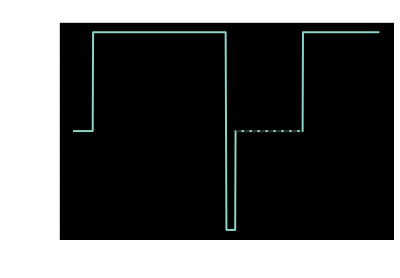

In [ ]:
# Create data frame 
data = np.zeros([800,1])
design_ec = pd.DataFrame(data = data, columns = ['disturbance'])
design_ec['disturbance'][0:49] = 0 # null trials 
design_ec['disturbance'][50:399] = 1 # adaptation trials 
design_ec['disturbance'][400:424] = -1 # de-adaptation trials 
design_ec['disturbance'][425:600] = 0 # error clamp trials
design_ec['disturbance'][601:800] = 1 # re-adaptation trials 

# Plot 
plt.figure()
plt.plot(design_ec['disturbance'], linewidth=2)
plt.plot(np.arange(425,600), [0] * 175, linestyle='--', color='k')
plt.xlabel('Trial #')
plt.ylabel('Disturbance')
plt.title('Paradigm for Relearning Experiment with Washout')
plt.show()

## D

### Single-State Model 

$x(n+1) = A \cdot x(n) + B \cdot e(n)$

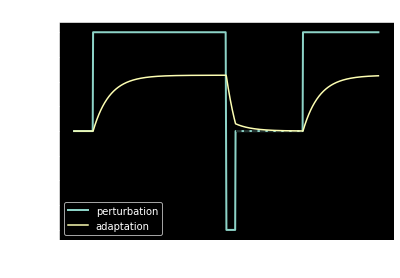

In [ ]:
# Create data frame
data = np.zeros([800,2])
design_ec_single = pd.DataFrame(data = data, 
                             columns = ['disturbance', 'x'])
design_ec_single['disturbance'] = design_ec['disturbance']

# rates
A = 0.99
B = 0.013
# ICs
x = 0 

# Simulate 
er = np.zeros(shape=[800,1])
for i in np.arange(0,799):
  # error 
  er[i] = design_ec_single['disturbance'][i] - design_ec_single['x'][i]

  # adaptation 
  design_ec_single['x'][i+1] = A * x + B * er[i]

  # update 
  x = design_ec_single['x'][i+1]

# plot 
plt.figure()
plt.plot(design_ec_single['disturbance'], linewidth=2, label='perturbation')
plt.plot(np.arange(425,600), [0] * 175, linestyle='--', color='k')
plt.plot(design_ec_single['x'], label='adaptation')
# plt.plot(er, label='error')
plt.xlabel('Trial #')
plt.ylabel('Adaptation')
plt.title('Single State Model')
plt.legend(loc='best')
plt.show()

### Gain-Specific Model 

$x_1(n+1) = min(0, [A \cdot x_1(n) + B \cdot e(n)])$

$x_2(n+1) = max(0, [A \cdot x_2(n) + B \cdot e(n)])$

$B_f > B_s, A_s > A_f$

$x = x_1 + x_2$

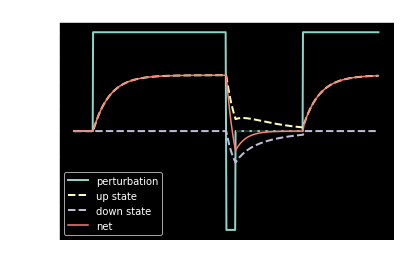

In [ ]:
# Create data frame
data = np.zeros([800,5])
design_ec_gain = pd.DataFrame(data = data, 
                             columns = ['disturbance', 'x', 'up', 'down', 'net'])
design_ec_gain['disturbance'] = design_ec['disturbance']

# ICs
x_1 = 0 
x_2 = 0

# Simulate 
for i in np.arange(0,799): 
  # error 
  er = design_ec_gain['disturbance'][i] - design_ec_gain['net'][i]
  # up state (somehow need to max)
  design_ec_gain['up'][i+1] = np.max([0, A * x_1 + B * er])
  # down state (somehow need to min)
  design_ec_gain['down'][i+1] = np.min([0, A * x_2 + B * er])
  # net 
  design_ec_gain['net'][i+1] = design_ec_gain['up'][i+1] + design_ec_gain['down'][i+1]
  # update 
  x_1 = design_ec_gain['up'][i+1]
  x_2 = design_ec_gain['down'][i+1]

# plot 
plt.figure()
plt.plot(design_ec_gain['disturbance'], linewidth=2, label='perturbation')
plt.plot(np.arange(425,600), [0] * 175, linestyle='--', color='k')
plt.plot(design_ec_gain['up'], linewidth=2, linestyle='--', label='up state')
plt.plot(design_ec_gain['down'], linewidth=2, linestyle='--', label='down state')
plt.plot(design_ec_gain['net'], linewidth=1.5, label='net')
plt.xlabel('Trial #')
plt.ylabel('Adaptation')
plt.title('Gain-Specific Model')
plt.legend(loc='best')
plt.show()

### Multi-Rate Model

$x_1(n+1) = A_f \cdot x_1(n) + B_f \cdot e(n)$

$x_2(n+1) = A_s \cdot x_2(n) + B_s \cdot e(n)$

$B_f > B_s, A_s > A_f$

$x = x_1 + x_2$

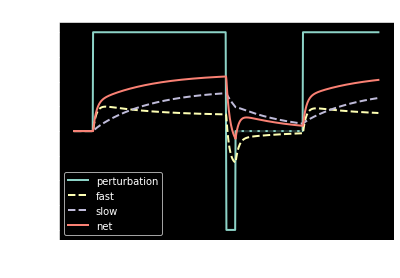

In [ ]:
# Create data frame
data = np.zeros([800,5])
design_ec_multi = pd.DataFrame(data = data, 
                             columns = ['disturbance', 'x', 'fast', 'slow', 'net'])
design_ec_multi['disturbance'] = design_ec['disturbance']

# rates
A_f = 0.92
A_s = 0.996
B_f = 0.03
B_s = 0.004

# ICs
x_1 = 0 
x_2 = 0

# Simulate 
for i in np.arange(0,799):
  # error 
  er = design_ec_multi['disturbance'][i] - design_ec_multi['net'][i]
  # fast
  design_ec_multi['fast'][i+1] = (A_f * x_1) + (B_f * er)
  # slow
  design_ec_multi['slow'][i+1] = (A_s * x_2) + (B_s * er)
  # net
  design_ec_multi['net'][i+1] = design_ec_multi['fast'][i+1] + design_ec_multi['slow'][i+1]

  # update 
  x_1 = design_ec_multi['fast'][i+1]
  x_2 = design_ec_multi['slow'][i+1]

# plot 
plt.figure()
plt.plot(design_ec_multi['disturbance'], linewidth=2, label='perturbation')
plt.plot(np.arange(425,600), [0] * 175, linestyle='--', color='k')
plt.plot(design_ec_multi['fast'], linewidth=2, linestyle='--', label='fast')
plt.plot(design_ec_multi['slow'], linewidth=2, linestyle='--',label='slow')
plt.plot(design_ec_multi['net'], linewidth=2, label='net')
plt.xlabel('Trial #')
plt.ylabel('Adaptation')
plt.title('Multi-Rate Model')
plt.legend(loc='best')
plt.show()

---